# Pratique: Évaluation de modèle selon le nombre de prédicteurs 

* Dans le cas de l’apprentissage supervisé, un ensemble de prédicteurs doit être choisi. Dans ce cadre, on va procéder à
* l’exploration du dataset pour établir la pertinence d’utiliser certaines des variables disponibles dans le dataset. 
* Un prétraitement pourra aussi être appliqué sur le dataset afin de corriger des valeurs manquantes ou aberrantes.


# Les étapes sont les suivantes

1. Analyse de données
2. Summarize data
 * Structure des données

3. Évaluation de modèles sur la base de l’erreur RSS
 * Recherche de prédicteurs pertinents avec recherche exhaustive de combinaisons adéquates de prédicteurs
 

* Références
 1. “Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshiran


# Processus

* Importation des modules nécessaires

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

* chargement du dataset

In [4]:
df = pd.read_csv('Hitters.csv')

* Description du dataset - Shape

In [5]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print(df.shape)

(322, 21)


In [6]:
#Visualisation des 5 premieres lignes
df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [7]:
# Exploration de données - nom de lignes avec variable Salary manquants
print(df["Salary"].isnull().sum())

59


In [8]:
# Drop les lignes qui contiennent des valeurs manquante, ainsi que les noms de joueurs
df = df.dropna().drop('Player', axis=1)
# Print des dimensions du contenu du dataframe modifé (263 rows x 20 columns)
print(df.shape)
# One last check: should return 0
print(df["Salary"].isnull().sum())

(263, 20)
0


# Preparation du DataFrame pour la sélection

In [9]:
#Creation de variables numériques pour remplacer les var categorielles
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
 
y = df.Salary
# Drop the column with the independent variable (Salary), and columns for which we created dummy 
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1) 
# Print the dimensions of the modified  
print(X.shape)
#Visualisation des 5 premieres lignes
X.head()

(263, 19)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1.0,1.0,1.0
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0.0,1.0,0.0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1.0,0.0,1.0
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1.0,0.0,1.0
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0.0,1.0,0.0


* fonction pour un modele ayant une liste de predicteurs, retourne un dictionnaire

In [16]:
def processSubset(feature_set):
# Fit du model avec les predicteurs choisis -feature_set et calcul de RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"modele":regr, "RSS":RSS}

* fonction pour trouver le meilleur modele pour un nombre k donné de predicteurs

In [19]:
def getBestModel(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):# toutes les combinaisons de colonnes de X comme tuples
        results.append(processSubset(combo))
    # transformer le tout en dataframe pour une meilleure visualisation
    models = pd.DataFrame(results)
    #print(models.head())
    # Choisir le modele avec la valeur min de RSS
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Traitement de: ", models.shape[0], "modeles sur", k, "predicteurs en", (toc-tic), "secondes.")
    # Retourner le meilleur modele, avec d'autres information sur le modele
    return best_model

# Evaluation des modeles selon RSS

* But: on essaye den faire les permutations de variables et ensuite evaluer la mesure RSS

In [20]:
#Execution de la routine pour trouver le meilleur modele
models = pd.DataFrame(columns=["RSS", "modele"])

tic = time.time()
for i in range(1,3):
    models.loc[i] = getBestModel(i)
toc = time.time()
print("Total temps ecoulé:", (toc-tic), "secondes.")

('Traitement de: ', 19, 'modeles sur', 1, 'predicteurs en', 0.06299996376037598, 'secondes.')
('Traitement de: ', 171, 'modeles sur', 2, 'predicteurs en', 0.4240000247955322, 'secondes.')
('Total temps ecoul\xc3\xa9:', 0.5, 'secondes.')


In [25]:
#Detail d'un modele avec 2 predicteurs en utilisant la fonction summary() :
print(models.loc[2, "modele"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     416.7
Date:                Wed, 11 Jan 2017   Prob (F-statistic):           5.80e-82
Time:                        14:18:03   Log-Likelihood:                -1907.6
No. Observations:                 263   AIC:                             3819.
Df Residuals:                     261   BIC:                             3826.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.0

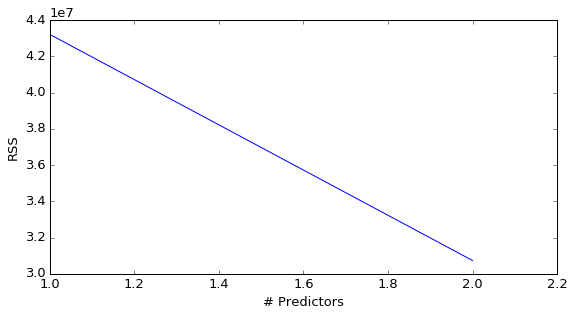

In [28]:
#Plotting RSSpour tous les modeles pour decider  modele à selectionner

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 13, 'lines.markersize': 10})
# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)
# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

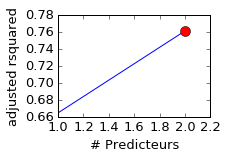

In [29]:
# plot a red dot pour le modele avec la plus grande R2 ajustée.
# The argmax() function can be used to identify the location of the maximum point of a vector
rsquared = models.apply(lambda row: row[1].rsquared, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared)
plt.plot(rsquared.argmax(), rsquared.max(), "or")
plt.xlabel('# Predicteurs')
plt.ylabel('adjusted rsquared')